# Laboratorio 7 — Deep Q‑Learning (DQN) con Red Objetivo para CartPole
CC3045 – Deep Learning y Sistemas Inteligentes


## 1) Instalación de dependencias

In [2]:
 !pip install gymnasium torch numpy matplotlib

import sys, os, math, random, time
import numpy as np
import torch, torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import deque, namedtuple
from dataclasses import dataclass
from pathlib import Path

print('PyTorch:', torch.__version__, '| Gymnasium:', gym.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


   ---------------------------------------- 0.0/965.4 kB ? eta -:--:--
   --------------------- ------------------ 524.3/965.4 kB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 965.4/965.4 kB 4.5 MB/s  0:00:00

   ------------- -------------------------- 1/3 [cloudpickle]
   -------------------------- ------------- 2/3 [gymnasium]
   -------------------------- ------------- 2/3 [gymnasium]
   -------------------------- ------------- 2/3 [gymnasium]
   -------------------------- ------------- 2/3 [gymnasium]
   -------------------------- ------------- 2/3 [gymnasium]
   -------------------------- ------------- 2/3 [gymnasium]
   -------------------------- ------------- 2/3 [gymnasium]
   -------------------------- ------------- 2/3 [gymnasium]
   -------------------------- ------------- 2/3 [gymnasium]
   -------------------------- ------------- 2/3 [gymnasium]
   -------------------------- ------------- 2/3 [gymnasium]
   -------------------------- ------------- 2/3 [

'cpu'

## 2) Configuración e Hiperparámetros

In [ ]:
@dataclass
class Config:
    env_id: str = 'CartPole-v1'
    episodes: int = 500
    max_steps: int = 500
    buffer_size: int = 50_000
    batch_size: int = 64
    gamma: float = 0.99
    lr: float = 1e-3
    epsilon_start: float = 1.0
    epsilon_end: float = 0.05
    epsilon_decay_steps: int = 5000   # steps para decaer epsilon
    target_update_steps: int = 1000   # cada cuántos steps sincronizar red objetivo
    hidden: int = 128
    grad_clip: float = 10.0
    seed: int = 42
    outdir: str = 'outputs'
    save_model: str = 'dqn_cartpole.pt'
    render_training: bool = False     # Cambiar a True para intentar render en entrenamiento 
    render_eval: bool = False         # Render en evaluación
cfg = Config()

# Fijar semilla
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(cfg.seed)
Path(cfg.outdir).mkdir(parents=True, exist_ok=True)
cfg


Config(env_id='CartPole-v1', episodes=500, max_steps=500, buffer_size=50000, batch_size=64, gamma=0.99, lr=0.001, epsilon_start=1.0, epsilon_end=0.05, epsilon_decay_steps=5000, target_update_steps=1000, hidden=128, grad_clip=10.0, seed=42, outdir='outputs', save_model='dqn_cartpole.pt', render_training=False, render_eval=False)

## 3) Red Q, Replay Buffer y Política ε‑greedy

In [4]:
Transition = namedtuple('Transition', ['state','action','reward','next_state','done'])

class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)
    def push(self, *args):
        self.buffer.append(Transition(*args))
    def sample(self, batch_size: int, device='cpu'):
        batch = random.sample(self.buffer, batch_size)
        states = torch.tensor(np.array([t.state for t in batch]), dtype=torch.float32, device=device)
        actions = torch.tensor([t.action for t in batch], dtype=torch.long, device=device).unsqueeze(1)
        rewards = torch.tensor([t.reward for t in batch], dtype=torch.float32, device=device).unsqueeze(1)
        next_states = torch.tensor(np.array([t.next_state for t in batch]), dtype=torch.float32, device=device)
        dones = torch.tensor([t.done for t in batch], dtype=torch.float32, device=device).unsqueeze(1)
        return states, actions, rewards, next_states, dones
    def __len__(self): return len(self.buffer)

class QNetwork(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden: int = 128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, action_dim)
        )
    def forward(self, x): return self.net(x)

def epsilon_greedy_action(q_network, state, epsilon, action_dim, device):
    if random.random() < epsilon:
        return random.randrange(action_dim)
    with torch.no_grad():
        state_t = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        q_values = q_network(state_t)
        return int(torch.argmax(q_values, dim=1).item())


## 4) Paso de actualización y Evaluación

In [5]:
def update_step(online_net, target_net, optimizer, replay, batch_size, gamma, device, grad_clip=None):
    states, actions, rewards, next_states, dones = replay.sample(batch_size, device=device)
    # Q(s,a)
    q_values = online_net(states).gather(1, actions)
    # y = r + γ max_a' Q_target(s', a') * (1 - done)
    with torch.no_grad():
        next_q = target_net(next_states).max(1, keepdim=True)[0]
        target = rewards + gamma * next_q * (1.0 - dones)
    loss = nn.functional.smooth_l1_loss(q_values, target)
    optimizer.zero_grad()
    loss.backward()
    if grad_clip is not None:
        nn.utils.clip_grad_norm_(online_net.parameters(), grad_clip)
    optimizer.step()
    return float(loss.item())

def evaluate(env_id, policy_net, episodes=10, render=False, device='cpu', seed=123):
    env = gym.make(env_id, render_mode='human' if render else None)
    scores = []
    for ep in range(episodes):
        obs, info = env.reset(seed=seed+ep)
        done = trunc = False
        total = 0.0
        while not (done or trunc):
            with torch.no_grad():
                a = int(torch.argmax(policy_net(torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)), dim=1).item())
            obs, r, done, trunc, info = env.step(a)
            total += r
        scores.append(total)
    if render:
        env.close()
    return float(np.mean(scores)), scores


## 5) Entrenamiento

In [6]:
env = gym.make(cfg.env_id, render_mode='human' if cfg.render_training else None)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

online = QNetwork(state_dim, action_dim, hidden=cfg.hidden).to(device)
target = QNetwork(state_dim, action_dim, hidden=cfg.hidden).to(device)
target.load_state_dict(online.state_dict())
target.eval()

optimizer = optim.Adam(online.parameters(), lr=cfg.lr)
replay = ReplayBuffer(cfg.buffer_size)

epsilon = cfg.epsilon_start
epsilon_decay_rate = (cfg.epsilon_start - cfg.epsilon_end) / max(1, cfg.epsilon_decay_steps)

global_step = 0
episode_rewards, losses = [], []

for ep in range(cfg.episodes):
    obs, info = env.reset(seed=cfg.seed + ep)
    done = trunc = False
    ep_reward = 0.0

    for t in range(cfg.max_steps):
        action = epsilon_greedy_action(online, obs, epsilon, action_dim, device)
        next_obs, reward, done, trunc, info = env.step(action)
        ep_reward += reward
        replay.push(obs, action, reward, next_obs, float(done or trunc))
        obs = next_obs
        global_step += 1

        # Anneal epsilon
        if epsilon > cfg.epsilon_end:
            epsilon = max(cfg.epsilon_end, epsilon - epsilon_decay_rate)

        # Learn
        if len(replay) >= cfg.batch_size:
            loss = update_step(online, target, optimizer, replay, cfg.batch_size, cfg.gamma, device, grad_clip=cfg.grad_clip)
            losses.append(loss)

        # Target update
        if global_step % cfg.target_update_steps == 0:
            target.load_state_dict(online.state_dict())

        if done or trunc:
            break

    episode_rewards.append(ep_reward)

    if (ep+1) % 10 == 0:
        print(f"Ep {ep+1:4d} | avg(10)={np.mean(episode_rewards[-10:]):6.2f} | eps={epsilon:5.3f} | buffer={len(replay)}")

    # criterio solved 
    if len(episode_rewards) >= 100 and np.mean(episode_rewards[-100:]) >= 475.0:
        print(f"Solved at episode {ep+1} with avg100={np.mean(episode_rewards[-100:]):.2f}")
        break

# Guardar pesos
torch.save(online.state_dict(), cfg.save_model)
print('Modelo guardado en', cfg.save_model)
env.close()


Ep   10 | avg(10)= 18.50 | eps=0.965 | buffer=185
Ep   20 | avg(10)= 24.80 | eps=0.918 | buffer=433
Ep   30 | avg(10)= 14.60 | eps=0.890 | buffer=579
Ep   40 | avg(10)= 28.10 | eps=0.837 | buffer=860
Ep   50 | avg(10)= 22.90 | eps=0.793 | buffer=1089
Ep   60 | avg(10)= 22.90 | eps=0.750 | buffer=1318
Ep   70 | avg(10)= 21.90 | eps=0.708 | buffer=1537
Ep   80 | avg(10)= 19.80 | eps=0.670 | buffer=1735
Ep   90 | avg(10)= 26.50 | eps=0.620 | buffer=2000
Ep  100 | avg(10)= 23.70 | eps=0.575 | buffer=2237
Ep  110 | avg(10)= 22.50 | eps=0.532 | buffer=2462
Ep  120 | avg(10)= 35.40 | eps=0.465 | buffer=2816
Ep  130 | avg(10)= 24.30 | eps=0.419 | buffer=3059
Ep  140 | avg(10)= 48.60 | eps=0.326 | buffer=3545
Ep  150 | avg(10)= 40.70 | eps=0.249 | buffer=3952
Ep  160 | avg(10)= 79.30 | eps=0.098 | buffer=4745
Ep  170 | avg(10)=139.20 | eps=0.050 | buffer=6137
Ep  180 | avg(10)=115.40 | eps=0.050 | buffer=7291
Ep  190 | avg(10)= 94.90 | eps=0.050 | buffer=8240
Ep  200 | avg(10)=124.30 | eps=0.05

## 6) Monitoreo — Gráficas

Gráfica guardada en outputs\reward_curve.png


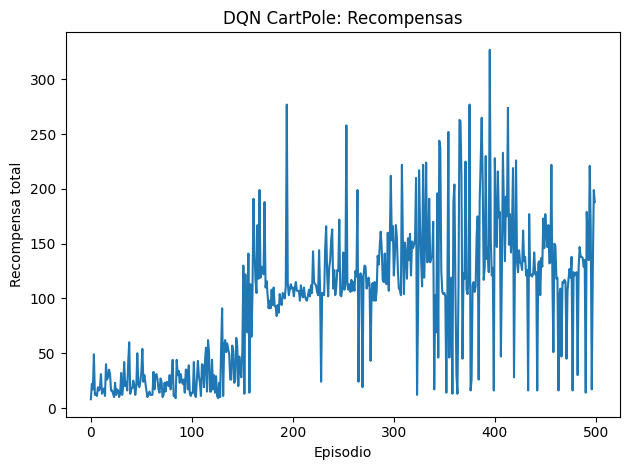

Gráfica guardada en outputs\loss_curve.png


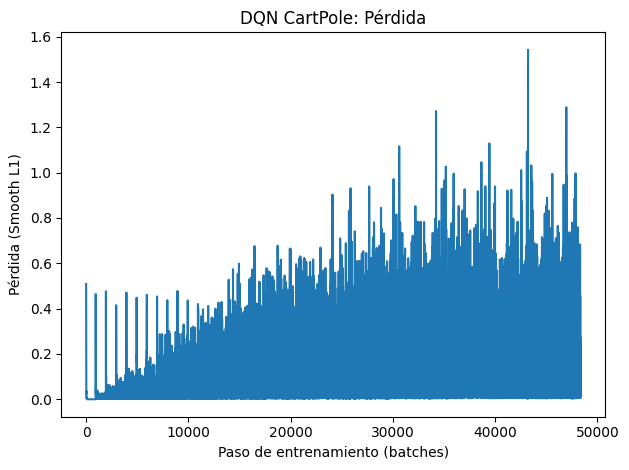

In [7]:
# Recompensas por episodio
plt.figure()
plt.plot(episode_rewards)
plt.xlabel('Episodio'); plt.ylabel('Recompensa total'); plt.title('DQN CartPole: Recompensas')
plt.tight_layout()
plt.savefig(Path(cfg.outdir)/'reward_curve.png')
print('Gráfica guardada en', Path(cfg.outdir)/'reward_curve.png')
plt.show()

# Pérdida de entrenamiento (opcional)
if len(losses) > 0:
    plt.figure()
    plt.plot(losses)
    plt.xlabel('Paso de entrenamiento (batches)'); plt.ylabel('Pérdida (Smooth L1)'); plt.title('DQN CartPole: Pérdida')
    plt.tight_layout()
    plt.savefig(Path(cfg.outdir)/'loss_curve.png')
    print('Gráfica guardada en', Path(cfg.outdir)/'loss_curve.png')
    plt.show()


## 7) Evaluación

In [8]:
# Cargar y evaluar el modelo entrenado
policy = QNetwork(state_dim, action_dim, hidden=cfg.hidden).to(device)
policy.load_state_dict(torch.load(cfg.save_model, map_location=device))
mean_r, scores = evaluate(cfg.env_id, policy, episodes=10, render=cfg.render_eval, device=device)
print(f'[EVAL] Recompensa media en 10 episodios: {mean_r:.2f}')
scores


[EVAL] Recompensa media en 10 episodios: 138.00


[135.0, 146.0, 138.0, 134.0, 135.0, 137.0, 141.0, 133.0, 138.0, 143.0]